In [21]:
import sys
sys.path.append(r'../STitch3D_N2/')

import utils
import model_step1
import networks_step1
import align_tools

import pandas as pd
import numpy as np
import scanpy as sc
import anndata as ad
from scipy.io import mmread
import os
# import sys

# import STitch3D

import warnings
warnings.filterwarnings("ignore")

os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [22]:
import torch
print(torch.__version__)
print(torch.cuda.is_available())

1.13.0+cu117
True


In [23]:

DATA_PATH = "/home/share/zw/SpatialScope/demo/demo_data/"
SAVE_PATH = "math5472/results_nobatch"

In [ ]:
adata_ref = sc.read(DATA_PATH + 'Ref_Heart_sanger_D2.h5ad')
adata_ref.var_names_make_unique()
adata_ref.X = np.expm1(adata_ref.X).astype('int').copy()
adata_ref

AnnData object with n_obs × n_vars = 17369 × 27477
    obs: 'NRP', 'age_group', 'cell_source', 'cell_type', 'donor', 'gender', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'region', 'sample', 'scrublet_score', 'source', 'type', 'version', 'cell_states', 'Used'
    var: 'gene_ids-Harvard-Nuclei', 'feature_types-Harvard-Nuclei', 'gene_ids-Sanger-Nuclei', 'feature_types-Sanger-Nuclei', 'gene_ids-Sanger-Cells', 'feature_types-Sanger-Cells', 'gene_ids-Sanger-CD45', 'feature_types-Sanger-CD45', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'Marker'
    uns: 'cell_states_colors', 'cell_type_colors', 'hvg', 'log1p', 'neighbors', 'pca', 'rank_genes_groups', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [6]:
adata_raw = sc.read(DATA_PATH + 'V1_Human_Heart_spatial.h5ad')
adata_raw.var_names_make_unique()
adata_raw.X = np.expm1(adata_raw.X).astype('int').copy()
adata_raw.layers['raw_counts'] = adata_raw.X.copy()
# adata_raw

In [8]:
# adata_raw.obs = pd.merge(adata_raw.obs, sp, left_index=True, right_index=True, how='inner')

adata_raw.obs['slice_ID']="slice_1"

# adata_raw.obs['raw_y'] = adata_raw.obs['pxl_row_in_fullres'].values
# adata_raw.obs['raw_x'] = adata_raw.obs['pxl_col_in_fullres'].values
adata_raw.obs['raw_y'] = adata_raw.obsm['spatial'][:,1]
adata_raw.obs['raw_x'] = adata_raw.obsm['spatial'][:,0]
# adata_raw.obs['new_y'] = adata_raw.obs['pxl_row_in_fullres'].values
# adata_raw.obs['new_x'] = adata_raw.obs['pxl_col_in_fullres'].values
adata_raw.obs['new_y'] = adata_raw.obsm['spatial'][:,1]
adata_raw.obs['new_x'] = adata_raw.obsm['spatial'][:,0]
adata_raw.obs['new_z'] = 0

# adata_raw.obsm['spatial'] = np.concatenate((adata_raw.obs['raw_x'].values.reshape(-1, 1),
#                                                  adata_raw.obs['raw_y'].values.reshape(-1, 1)), axis=1)
adata_raw.obsm['loc_use'] = np.concatenate((adata_raw.obs['raw_x'].values.reshape(-1, 1),
                                                 adata_raw.obs['raw_y'].values.reshape(-1, 1)), axis=1)
adata_raw.obsm['coor_3d'] = np.concatenate((adata_raw.obs['new_x'].values.reshape(-1, 1),
                                                 adata_raw.obs['new_y'].values.reshape(-1, 1),
                                                 adata_raw.obs['new_z'].values.reshape(-1, 1)), axis=1)

# adata_raw.write(filename=DATA_PATH+"V1_Human_Heart_spatial.h5ad")

adata_raw

AnnData object with n_obs × n_vars = 4247 × 36601
    obs: 'in_tissue', 'array_row', 'array_col', 'sample', 'slice_ID', 'raw_y', 'raw_x', 'new_y', 'new_x', 'new_z'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial', 'loc_use', 'coor_3d'
    layers: 'raw_counts'

In [9]:
adata_raw_fake = adata_raw.copy()
adata_raw_fake.obsm['coor_3d'][:,2] = 100000
adata_raw_fake.obs['new_z'] = 100000
adata_raw_fake.obs['slice_ID'] = 'slice_2'
adata_raw_fake.obs.index = [s + '_fake' for s in adata_raw.obs.index.tolist()]
adata_raw_fake

AnnData object with n_obs × n_vars = 4247 × 36601
    obs: 'in_tissue', 'array_row', 'array_col', 'sample', 'slice_ID', 'raw_y', 'raw_x', 'new_y', 'new_x', 'new_z'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial', 'loc_use', 'coor_3d'
    layers: 'raw_counts'

In [10]:
adata_st_list_raw = []
adata_st_list_raw.append(adata_raw.copy())
adata_st_list_raw.append(adata_raw_fake.copy())
adata_st_list_raw

[AnnData object with n_obs × n_vars = 4247 × 36601
     obs: 'in_tissue', 'array_row', 'array_col', 'sample', 'slice_ID', 'raw_y', 'raw_x', 'new_y', 'new_x', 'new_z'
     var: 'gene_ids', 'feature_types', 'genome'
     uns: 'spatial'
     obsm: 'spatial', 'loc_use', 'coor_3d'
     layers: 'raw_counts',
 AnnData object with n_obs × n_vars = 4247 × 36601
     obs: 'in_tissue', 'array_row', 'array_col', 'sample', 'slice_ID', 'raw_y', 'raw_x', 'new_y', 'new_x', 'new_z'
     var: 'gene_ids', 'feature_types', 'genome'
     uns: 'spatial'
     obsm: 'spatial', 'loc_use', 'coor_3d'
     layers: 'raw_counts']

In [12]:
adata_st, adata_basis = utils.preprocess(adata_st_list,
                                                  adata_ref,
                                                  celltype_ref_col="cell_type",
                                                  sample_col="sample",
                                                  n_hvg_group=500)

Finding highly variable genes...


3436 highly variable genes selected.
Calculate basis for deconvolution...
11 batches are used for computing the basis vector of cell type <Adipocytes>.
4 batches are used for computing the basis vector of cell type <Atrial_Cardiomyocyte>.
12 batches are used for computing the basis vector of cell type <Endothelial>.
12 batches are used for computing the basis vector of cell type <Fibroblast>.
12 batches are used for computing the basis vector of cell type <Lymphoid>.
12 batches are used for computing the basis vector of cell type <Myeloid>.
12 batches are used for computing the basis vector of cell type <Neuronal>.
12 batches are used for computing the basis vector of cell type <Pericytes>.
12 batches are used for computing the basis vector of cell type <Smooth_muscle_cells>.
8 batches are used for computing the basis vector of cell type <Ventricular_Cardiomyocyte>.
Preprocess ST data...


Start building a graph...
Radius for graph connection is 150.7000.
12.7335 neighbors per cell on average.


In [15]:
model_step1 = model_step1.Model(adata_st, adata_basis)

model_step1.train()

  0%|                                                                     | 1/20000 [00:01<10:21:39,  1.87s/it]

Step: 0, Loss: nan, d_loss: nan, f_loss: nan


 10%|██████▋                                                            | 2001/20000 [22:30<3:34:28,  1.40it/s]

Step: 2000, Loss: nan, d_loss: nan, f_loss: nan


 20%|█████████████▍                                                     | 4001/20000 [44:59<3:10:39,  1.40it/s]

Step: 4000, Loss: nan, d_loss: nan, f_loss: nan


 30%|███████████████████▌                                             | 6001/20000 [1:07:27<2:46:46,  1.40it/s]

Step: 6000, Loss: nan, d_loss: nan, f_loss: nan


 40%|██████████████████████████                                       | 8001/20000 [1:29:56<2:23:11,  1.40it/s]

Step: 8000, Loss: nan, d_loss: nan, f_loss: nan


 50%|████████████████████████████████                                | 10001/20000 [1:52:24<1:59:02,  1.40it/s]

Step: 10000, Loss: nan, d_loss: nan, f_loss: nan


 60%|██████████████████████████████████████▍                         | 12001/20000 [2:14:53<1:35:19,  1.40it/s]

Step: 12000, Loss: nan, d_loss: nan, f_loss: nan


 70%|████████████████████████████████████████████▊                   | 14001/20000 [2:37:22<1:11:29,  1.40it/s]

Step: 14000, Loss: nan, d_loss: nan, f_loss: nan


 80%|████████████████████████████████████████████████████▊             | 16001/20000 [2:59:50<47:41,  1.40it/s]

Step: 16000, Loss: nan, d_loss: nan, f_loss: nan


 90%|███████████████████████████████████████████████████████████▍      | 18001/20000 [3:22:19<23:50,  1.40it/s]

Step: 18000, Loss: nan, d_loss: nan, f_loss: nan


100%|██████████████████████████████████████████████████████████████████| 20000/20000 [3:44:46<00:00,  1.48it/s]


In [16]:
result_step1 = model_step1.eval(adata_st_list_raw, save=True, output_path=SAVE_PATH+"step1")

In [20]:
result_step1[0].obs

,in_tissue,array_row,array_col,sample,slice_ID,raw_y,raw_x,new_y,new_x,new_z,Adipocytes,Atrial_Cardiomyocyte,Endothelial,Fibroblast,Lymphoid,Myeloid,Neuronal,Pericytes,Smooth_muscle_cells,Ventricular_Cardiomyocyte
AAACAAGTATCTCCCA-1-slice0,1,50,102,V1_Human_Heart,slice_1,8513,9811,8513,9811,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AAACACCAATAACTGC-1-slice0,1,59,19,V1_Human_Heart,slice_1,9605,4104,9605,4104,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AAACAGAGCGACTCCT-1-slice0,1,14,94,V1_Human_Heart,slice_1,4205,9250,4205,9250,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AAACAGCTTTCAGAAG-1-slice0,1,43,9,V1_Human_Heart,slice_1,7691,3412,7691,3412,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AAACAGGGTCTATATT-1-slice0,1,47,13,V1_Human_Heart,slice_1,8170,3688,8170,3688,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTGTTGTGTGTCAAGA-1-slice0,1,31,77,V1_Human_Heart,slice_1,6243,8086,6243,8086,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TTGTTTCACATCCAGG-1-slice0,1,58,42,V1_Human_Heart,slice_1,9481,5686,9481,5686,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TTGTTTCATTAGTCTA-1-slice0,1,60,30,V1_Human_Heart,slice_1,9723,4861,9723,4861,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TTGTTTCCATACAACT-1-slice0,1,45,27,V1_Human_Heart,slice_1,7928,4650,7928,4650,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Slice 1


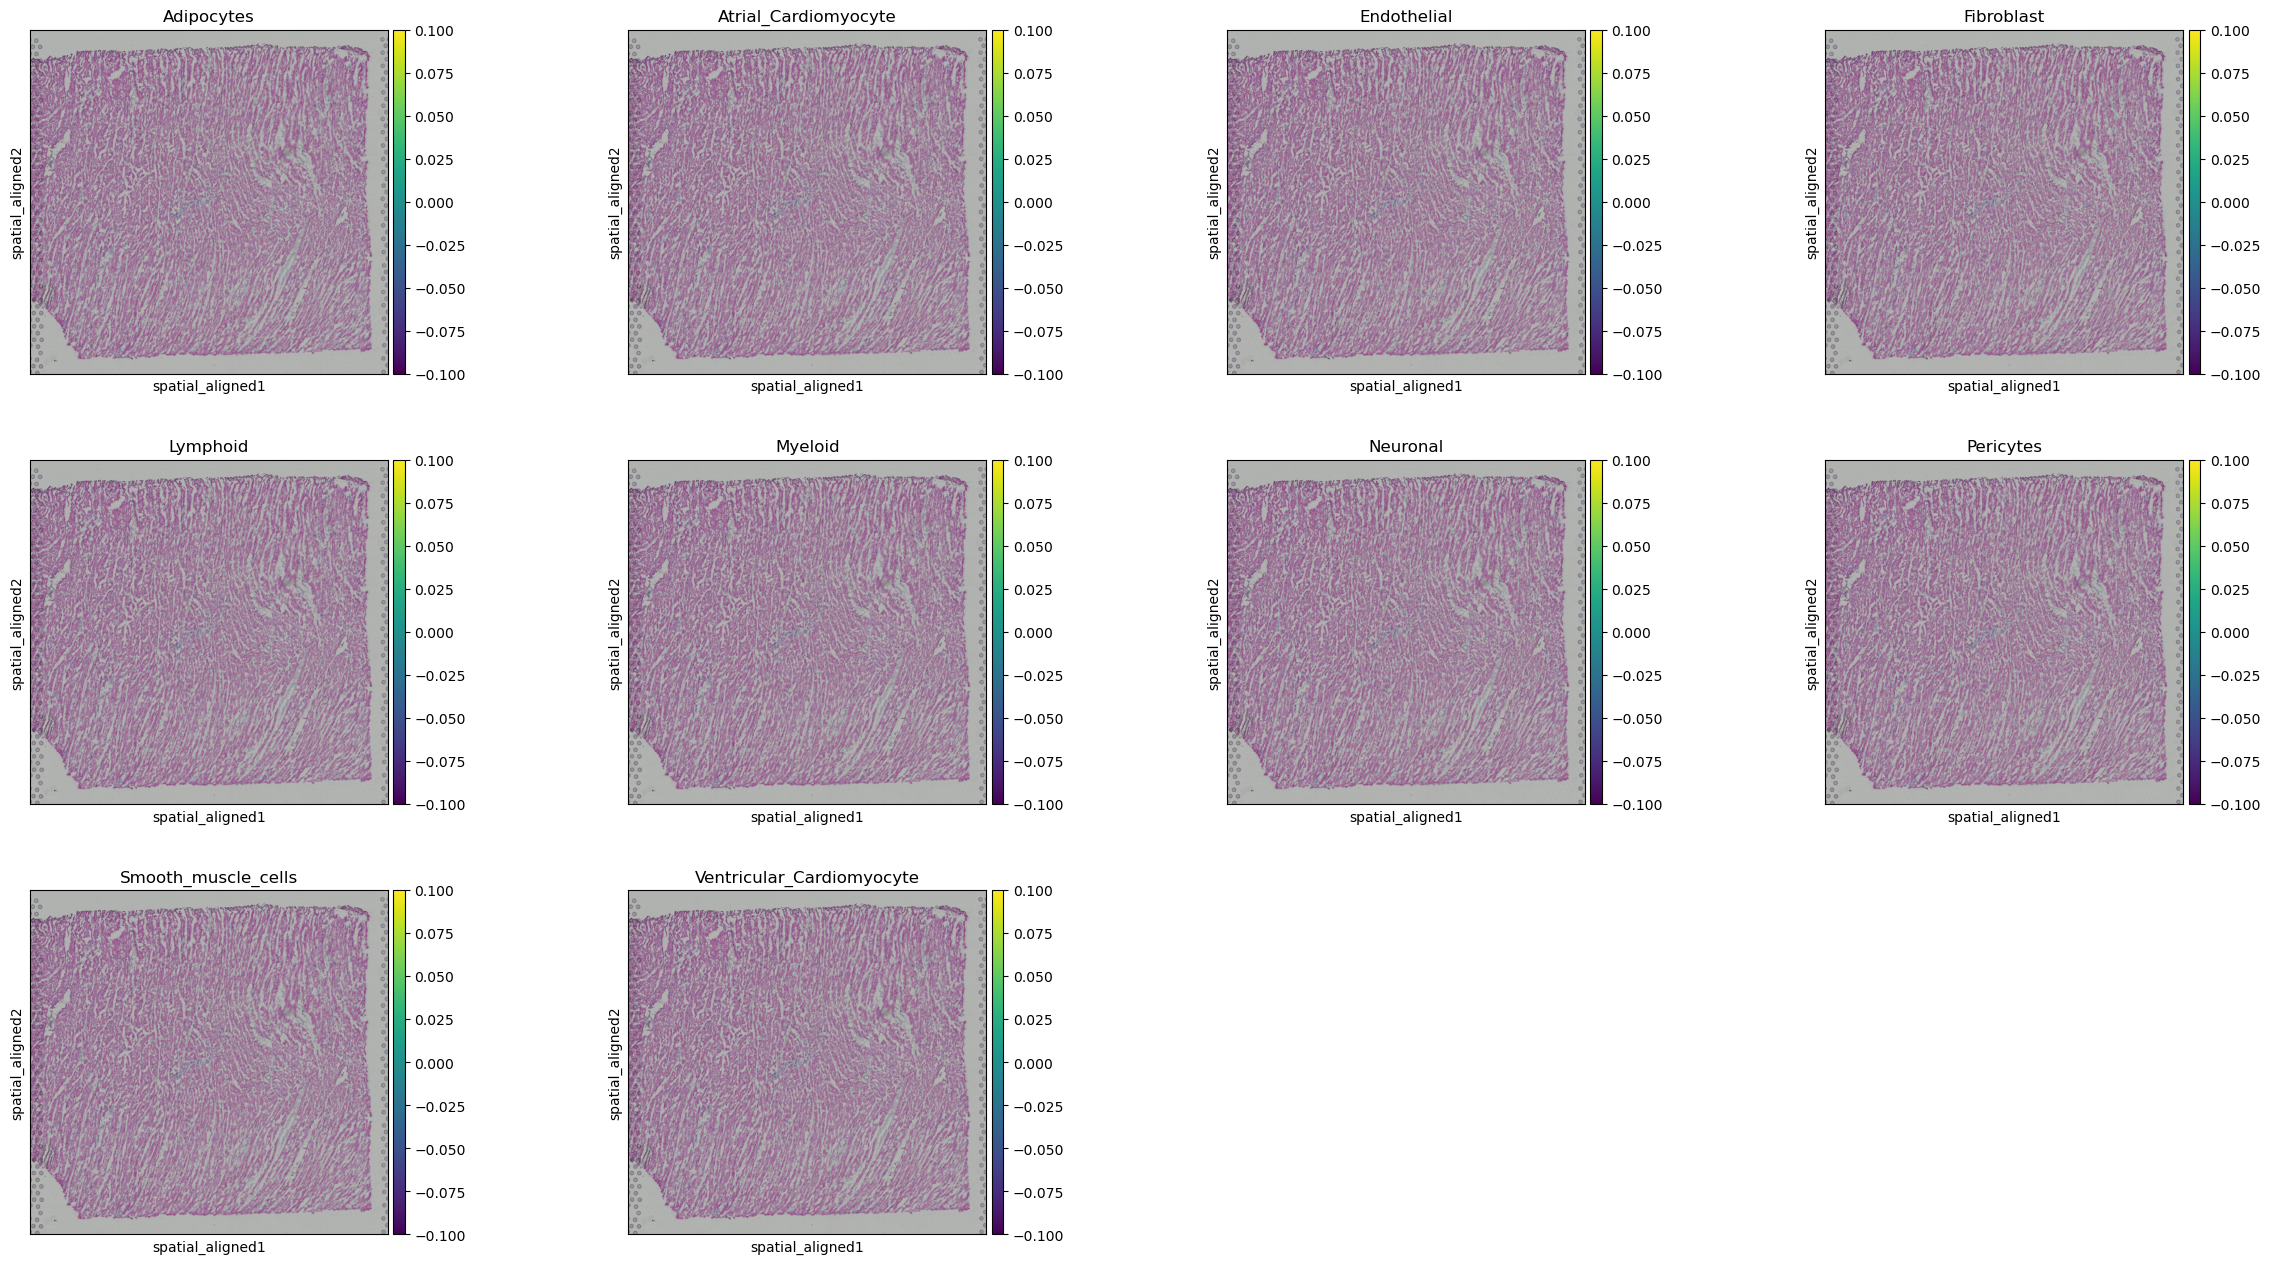

Slice 2


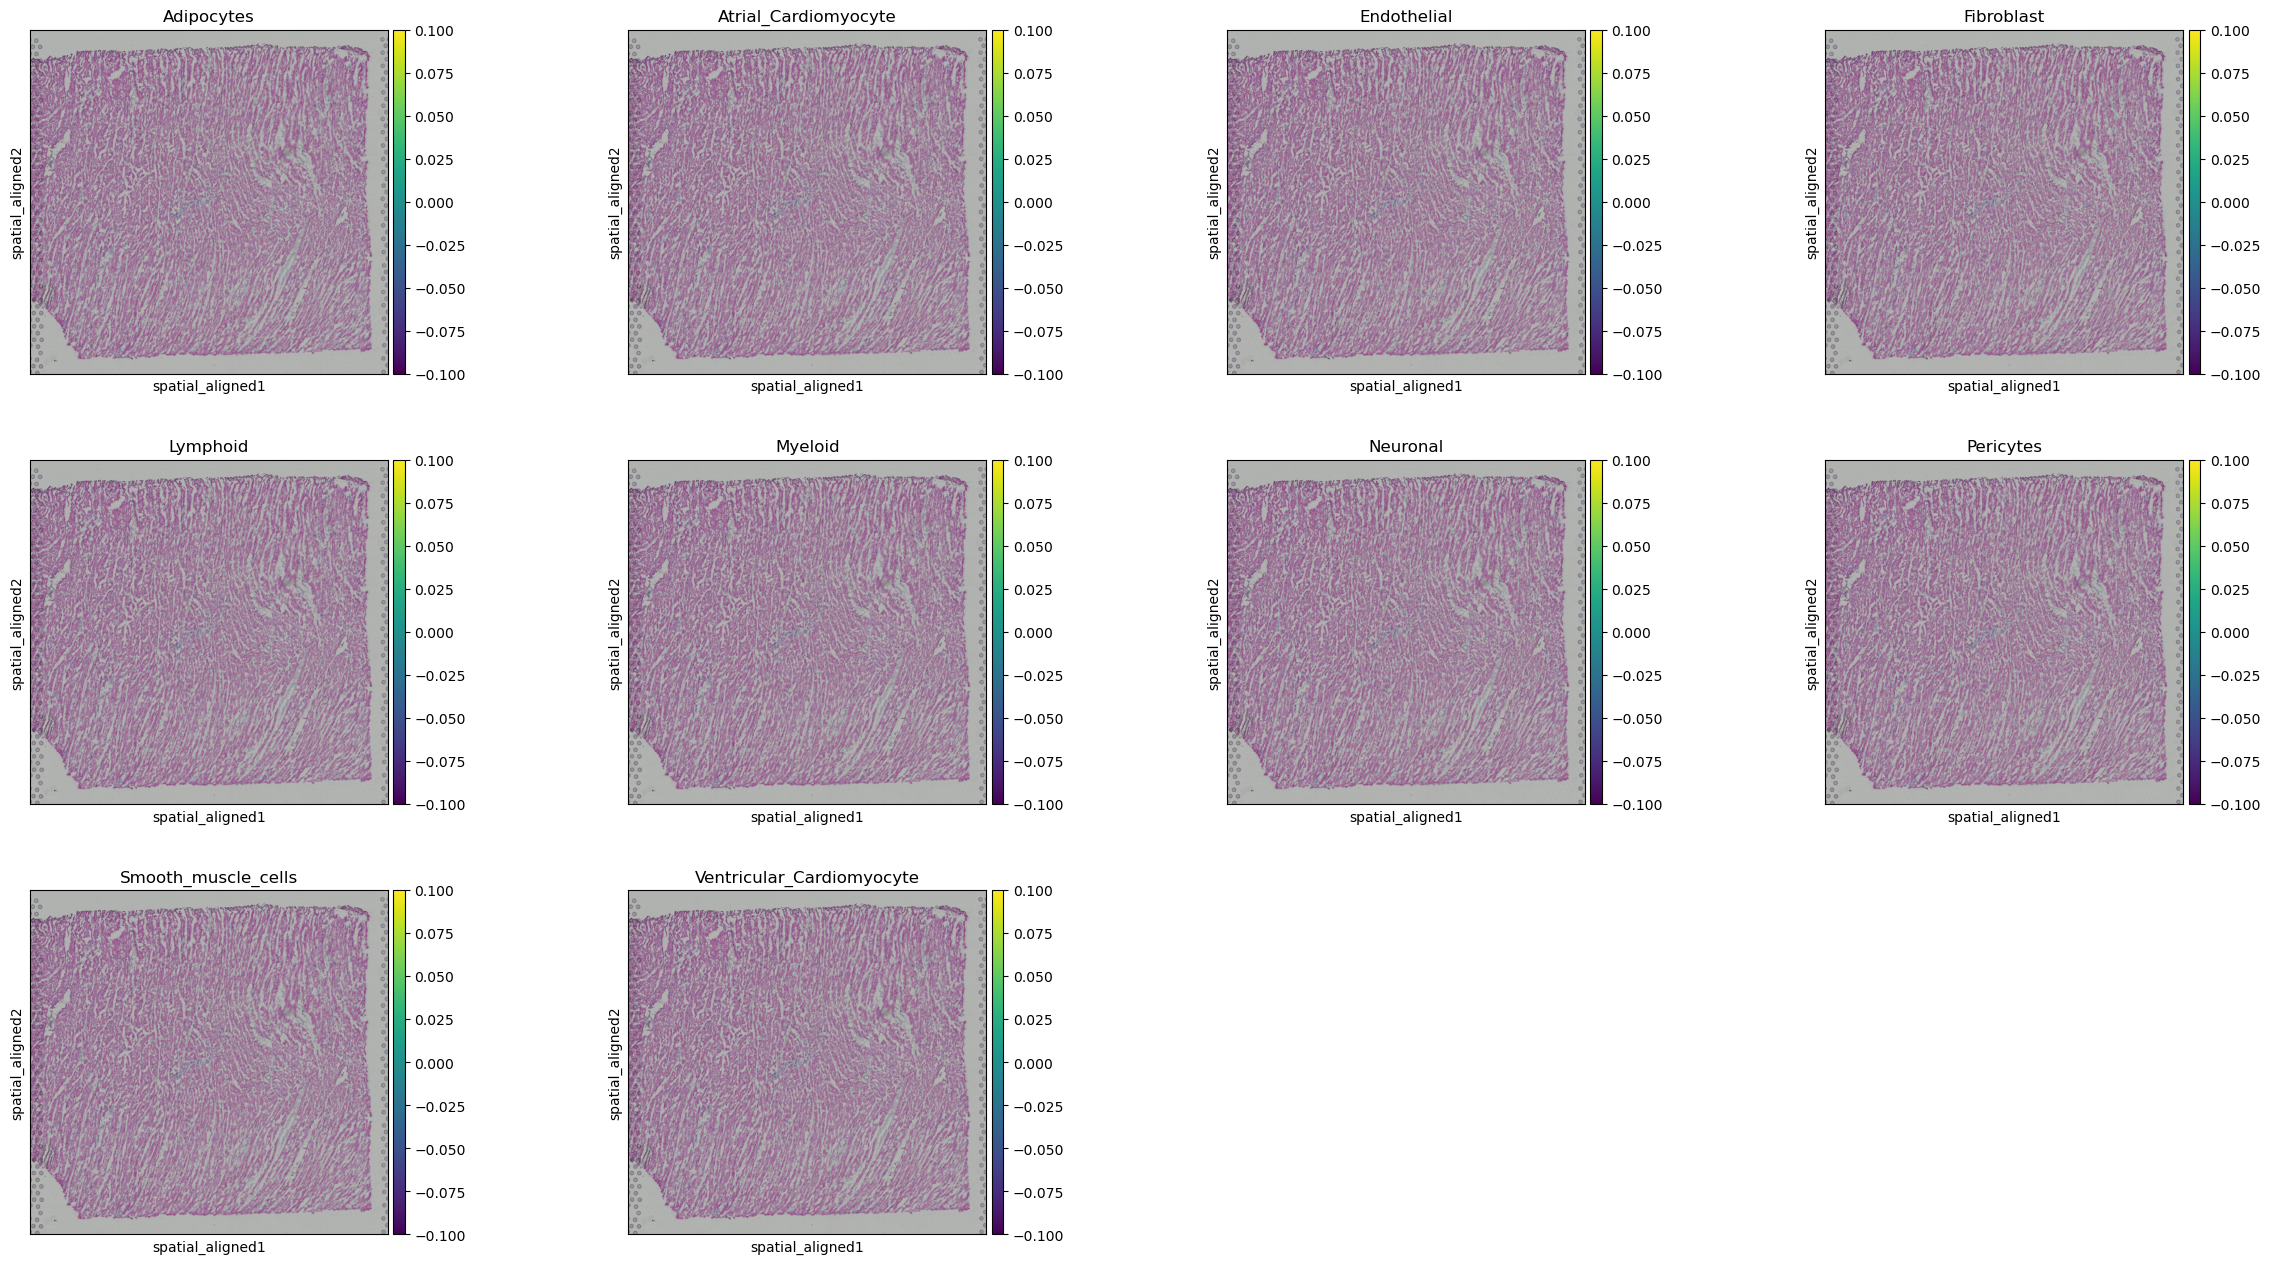

In [17]:
for i, adata_st_i in enumerate(result_step1):
    print("Slice %d" % (i+1))
    sc.pl.spatial(adata_st_i, img_key="hires", basis="spatial_aligned", color=model_step1.celltypes, spot_size=150.)